In [1]:
import os
import io
import trimesh
import b3d
import genjax
import jax
import b3d.bayes3d as bayes3d
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import json
import random
from copy import deepcopy
import itertools
import pycocotools.mask as mask_util
from scipy.spatial.transform import Rotation
from tqdm import tqdm
from functools import reduce
from genjax import Pytree
from physion_utils import *
import b3d.chisight.dense.dense_model
import b3d.chisight.dense.likelihoods.laplace_likelihood
import collections
from genjax._src.core.serialization.msgpack import msgpack_serialize

In [2]:
rr.init("demo")
rr.connect("127.0.0.1:8812")
rr.log("/", rr.ViewCoordinates.LEFT_HAND_Y_UP, static=True)  # Set an up-axis

## define helper functions

In [3]:
def scale_mesh(vertices, scale_factor):
    vertices_copy = deepcopy(vertices)
    vertices_copy[:, 0] *= scale_factor[0]
    vertices_copy[:, 1] *= scale_factor[1]
    vertices_copy[:, 2] *= scale_factor[2]
    return vertices_copy

def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.array([x, y, z, w])

def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype('float32')
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

def unproject_pixels(mask, depth_map, cam_matrix, fx, fy, vfov=54.43222, near_plane=0.1, far_plane=100):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    depth = depth_map[mask]
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def blackout_image(depth_map, area):
    # zero_depth_map = np.ones(depth_map.shape) * (-np.inf)
    zero_depth_map = np.zeros(depth_map.shape)
    zero_depth_map[area] = depth_map[area]
    return zero_depth_map

def color_image(depth_map, area, color):
    _depth_map = deepcopy(depth_map)
    _depth_map[area] = color
    return _depth_map

## load basic information from hdf5

In [4]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

resnet_inference_path = os.path.join(
    b3d.get_root_path(),
    "resnet_results/",)

stim_name = 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0012'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

mesh_file_path = os.path.join(physion_assets_path,
    f"all_flex_meshes/core",
)

json_file_path = os.path.join(resnet_inference_path,
    f"{stim_name}.json",
)

im_width = 350
im_height = 350

In [5]:
vfov = 54.43222 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap, cap_id = None, None, None, None, None, None, None, None, None
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = jnp.array(f['frames'][key]['images']['_depth_cam0'])
        depth_arr.append(depth)
        image = jnp.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
    depth_arr = jnp.asarray(depth_arr)
    image_arr = jnp.asarray(image_arr)/255
    FINAL_T, height, width = image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]

    # extract camera info
    camera_azimuth = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))
    projection_matrix = np.array(f['frames']['0000']['camera_matrices']['projection_matrix_cam0']).reshape((4, 4))
    im_seg = np.array(Image.open(io.BytesIO(f['frames']['0000']['images']['_id_cam0'][:])))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov

    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    assert len(object_ids) == len(model_names)

    distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else None
    occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else None
    assert distractors==None and occluders==None
    # distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    # occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
    # excluded_model_ids = distractor_ids+occluder_ids
    # included_model_ids = [idx for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    # object_ids = included_model_ids
    
    object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])
    initial_position = np.array(f['static']['initial_position'])
    initial_rotation = np.array(f['static']['initial_rotation'])
    scales = np.array(f['static']['scale'])
    if "base_id" in np.array(f['static']) and "attachment_id" in np.array(f['static']):
        base_id = np.array(f['static']['base_id'])
        base_type = np.array(f['static']['base_type'])
        attachment_id = np.array(f['static']['attachment_id'])
        attachent_type = np.array(f['static']['attachent_type'])
        attachment_fixed = np.array(f['static']['attachment_fixed'])
        use_attachment = np.array(f['static']['use_attachment'])
        link_type = np.array(f['static']['link_type'])
        use_base = np.array(f['static']['use_base'])
        use_cap = np.array(f['static']['use_cap'])
        assert attachment_id.size==1
        assert base_id.size==1
        attachment_id = attachment_id.item()
        base_id = base_id.item()
        if use_cap:
            cap_id = attachment_id+1
        print(base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap, link_type)

4 b'cylinder' 5 b'cylinder' True True True True b'torus'


In [6]:
cap_id

6

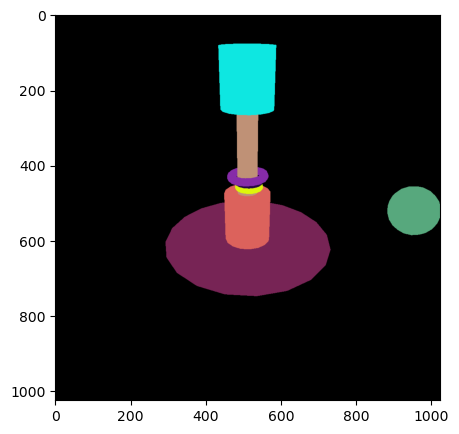

In [7]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax.imshow(im_seg)

In [8]:
counter = np.unique(im_seg.reshape(-1, im_seg.shape[2]), axis=0)
num_obj = counter.shape[0]-1
num_obj

8

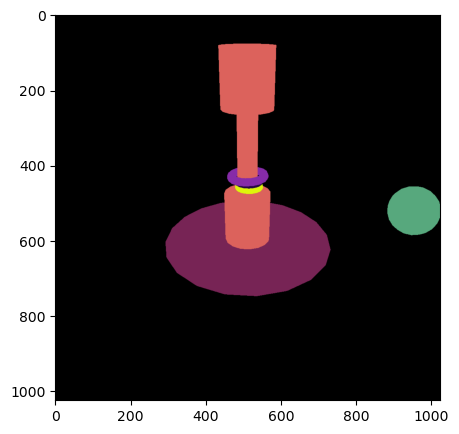

In [9]:
im_seg_copy = deepcopy(im_seg)

START_T = 0
interesting_ids = [base_id, attachment_id]
if cap_id:
    interesting_ids.append(cap_id)

# loop over all seg masks
for i, o_id in enumerate(interesting_ids):
    color = object_segmentation_colors[object_ids.tolist().index(o_id)]
    
    area = get_mask_area(im_seg, [color])
    if i == 0:
        consistent_color = color
    else:
        im_seg_copy = color_image(im_seg_copy, area, consistent_color)
    
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax.imshow(im_seg_copy)


In [10]:
counter = np.unique(im_seg_copy.reshape(-1, im_seg_copy.shape[2]), axis=0)
num_obj = counter.shape[0]-1
num_obj

6

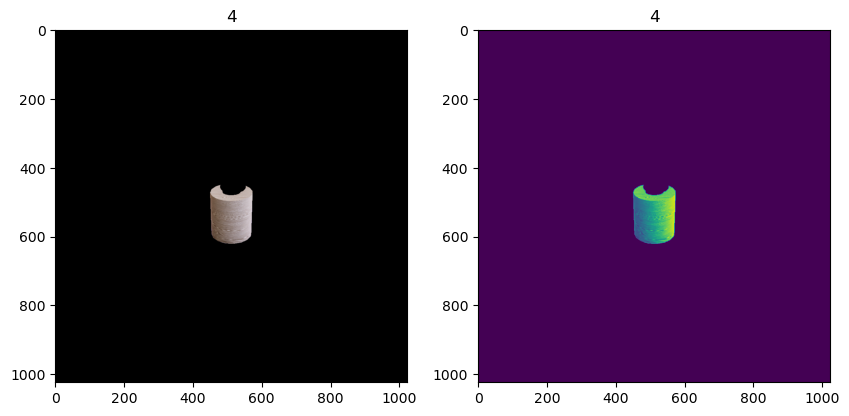

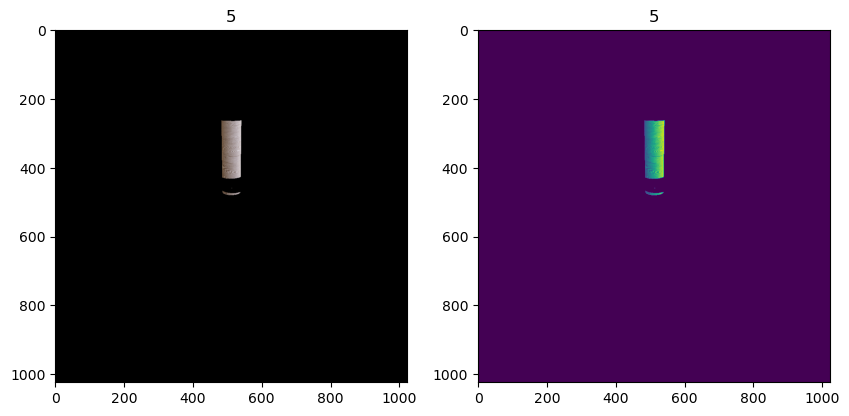

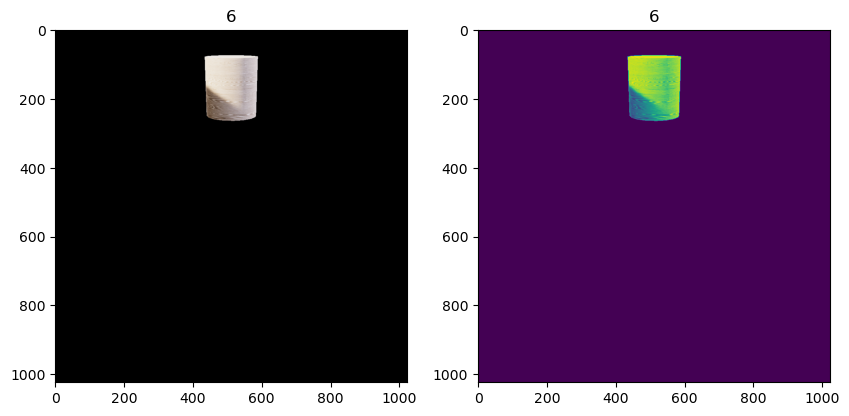

In [11]:
START_T = 0
interesting_ids = [base_id, attachment_id]
if cap_id:
    interesting_ids.append(cap_id)

# loop over all seg masks
for o_id in interesting_ids:
    color = object_segmentation_colors[object_ids.tolist().index(o_id)]
    area = get_mask_area(im_seg, [color])
    image_masked = blackout_image(image_arr[START_T], area)
    depth_map_masked = image_masked[..., -1]
    rgb_masked = image_masked[..., 0:3]

    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_subplot(121)
    ax.imshow(rgb_masked)
    ax.set_title(f"{o_id}")

    ax = fig.add_subplot(122)
    ax.imshow(depth_map_masked)
    ax.set_title(f"{o_id}")